In [85]:
import keras
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense,Bidirectional
from nltk.tokenize import word_tokenize,sent_tokenize
from keras.layers import *
from sklearn.model_selection import cross_val_score

!pip install tweet-preprocessor
import preprocessor as p
import nltk
import pandas as pd
import re
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [86]:
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
df = pd.read_csv('/content/drive/MyDrive/Emotion_final.csv', sep = ',')

In [89]:
df = df[df['Emotion'] != 'love']

In [90]:
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
...,...,...
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear


In [91]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [92]:
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [93]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#function to clean the tweets
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #calling the expand contraction function
        tweet = expandContractions(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets

In [94]:
import ftfy
X=clean_tweets([tweet for tweet in df['Text']])


In [95]:
df1 = pd.DataFrame(X, columns=['tweets'])
df1

,tweets
0,didnt feel humiliated
1,go feeling hopeless damned hopeful around some...
2,im grabbing minute post feel greedy wrong
3,feeling grouchy
4,ive feeling little burdened lately wasnt sure
...,...
19813,melissa stared friend dism
19814,successive state elections seen governing part...
19815,vincent irritated dismay
19816,kendall hume turned back face dismayed coup


In [96]:
feel_arr=df1['tweets']
#tokenizing the sentence
feel_arr = [word_tokenize(sentence) for sentence in feel_arr]
print(feel_arr[0])

['didnt', 'feel', 'humiliated']


In [97]:
#padding the sentences to create sentences of equal lengths
def padd(arr):
    for i in range(20-len(arr)):
        arr.append('<pad>')
    return arr[:20]
   

for i in range(len(feel_arr)):
    feel_arr[i]=padd(feel_arr[i])
 
print(feel_arr[0])

['didnt', 'feel', 'humiliated', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [98]:
vocab_f = '/content/drive/MyDrive/glove.6B.50d.txt'
# loading the embedding words from glove
embeddings_index = {}
with open(vocab_f, encoding='utf8') as f:
    for line in f:

        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
         

embeddings_index['happy']

array([ 0.092086,  0.2571  , -0.58693 , -0.37029 ,  1.0828  , -0.55466 ,
       -0.78142 ,  0.58696 , -0.58714 ,  0.46318 , -0.11267 ,  0.2606  ,
       -0.26928 , -0.072466,  1.247   ,  0.30571 ,  0.56731 ,  0.30509 ,
       -0.050312, -0.64443 , -0.54513 ,  0.86429 ,  0.20914 ,  0.56334 ,
        1.1228  , -1.0516  , -0.78105 ,  0.29656 ,  0.7261  , -0.61392 ,
        2.4225  ,  1.0142  , -0.17753 ,  0.4147  , -0.12966 , -0.47064 ,
        0.3807  ,  0.16309 , -0.323   , -0.77899 , -0.42473 , -0.30826 ,
       -0.42242 ,  0.055069,  0.38267 ,  0.037415, -0.4302  , -0.39442 ,
        0.10511 ,  0.87286 ], dtype=float32)

In [99]:
#creating the embedding matrix
embedded_feel_arr = []
for each_sentence in feel_arr:
    embedded_feel_arr.append([])
    for word in each_sentence:
        if word.lower() in embeddings_index:
            embedded_feel_arr[-1].append(embeddings_index[word.lower()])
        else:
            embedded_feel_arr[-1].append([0]*50)
             
print(embedded_feel_arr[0][0])

[ 0.37208  -1.6367   -0.01596  -0.71096  -0.091069 -0.64653   0.14935
  1.359    -0.73179   0.89379   0.48058   0.26045  -0.35272  -0.29421
  0.83736   0.76019   0.85588   0.065947  0.91954  -0.44967  -0.72178
  0.026336  0.29148   0.53179   1.0075    0.11035  -0.81848  -0.12967
  0.5763   -1.3032   -0.083632  1.4601   -0.40714   0.79689   0.085117
 -0.28072   0.21696   0.8038    0.63423  -0.21642  -0.3982   -0.5367
 -0.36871   0.76897  -0.4583   -0.06673   0.32085   0.87914  -0.54308
  0.57738 ]


In [100]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
X=np.array(embedded_feel_arr)
 
# One-hot enncoding is performed to the output labels
enc = OneHotEncoder(handle_unknown='ignore')
Y = enc.fit_transform(np.array(df['Emotion']).reshape(-1,1)).toarray()
 
# Splitting the data into train, test and validation set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2,random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,test_size=0.1,random_state=42)

In [101]:
print(enc.categories_)

[array(['anger', 'fear', 'happy', 'sadness', 'surprise'], dtype=object)]


In [109]:
from keras.layers import Dropout
import matplotlib.pyplot as plt
class BiLSTMModel:
  #defining the model class and its functions
    def __init__(self):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(100, input_shape=(20, 50))))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(5, activation='softmax'))
        self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        
 

    def fit(self, X, Y, epochs, batch_size,validation_data=(X_val, Y_val)):
        history = self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return history
        

    def plot_train_test_curve(self, history):
        fig, axs = plt.subplots(2, figsize=(14, 10))
    
        # summarize history for accuracy
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].set_title('Model Accuracy')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].legend(['Train', 'Test'], loc='upper left')
        
        # summarize history for loss
        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title('Model Loss')
        axs[1].set_ylabel('Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].legend(['Train', 'Test'], loc='upper left')

        plt.tight_layout()
        plt.show()
 
    def evaluate(self, X, Y, batch_size):
        return self.model.evaluate(X, Y, batch_size=batch_size)
 
    def predict(self, X):
        return self.model.predict(X)
        
    
    def save(self,loc):
      return self.model.save(loc)

In [110]:
from tensorflow.keras.callbacks import ModelCheckpoint
# create an instance of the BiLSTMModel class
model = BiLSTMModel()
# fit the model on the input and target data
histry=model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_val, Y_val))

Epoch 1/100
112/112 [==============================] - 23s 114ms/step - loss: 1.8281 - accuracy: 0.4516 - val_loss: 1.3744 - val_accuracy: 0.5410
Epoch 2/100
112/112 [==============================] - 11s 94ms/step - loss: 1.2669 - accuracy: 0.5505 - val_loss: 1.1680 - val_accuracy: 0.5618
Epoch 3/100
112/112 [==============================] - 13s 114ms/step - loss: 1.0932 - accuracy: 0.5943 - val_loss: 0.9726 - val_accuracy: 0.6526
Epoch 4/100
112/112 [==============================] - 12s 110ms/step - loss: 0.9745 - accuracy: 0.6419 - val_loss: 0.9092 - val_accuracy: 0.6715
Epoch 5/100
112/112 [==============================] - 13s 113ms/step - loss: 0.8782 - accuracy: 0.6798 - val_loss: 0.7906 - val_accuracy: 0.7144
Epoch 6/100
112/112 [==============================] - 14s 122ms/step - loss: 0.7937 - accuracy: 0.7150 - val_loss: 0.7421 - val_accuracy: 0.7478
Epoch 7/100
112/112 [==============================] - 12s 110ms/step - loss: 0.7351 - accuracy: 0.7460 - val_loss: 0.7249 - 

In [112]:
model.save('/content/drive/MyDrive/your_model_text20.h5')

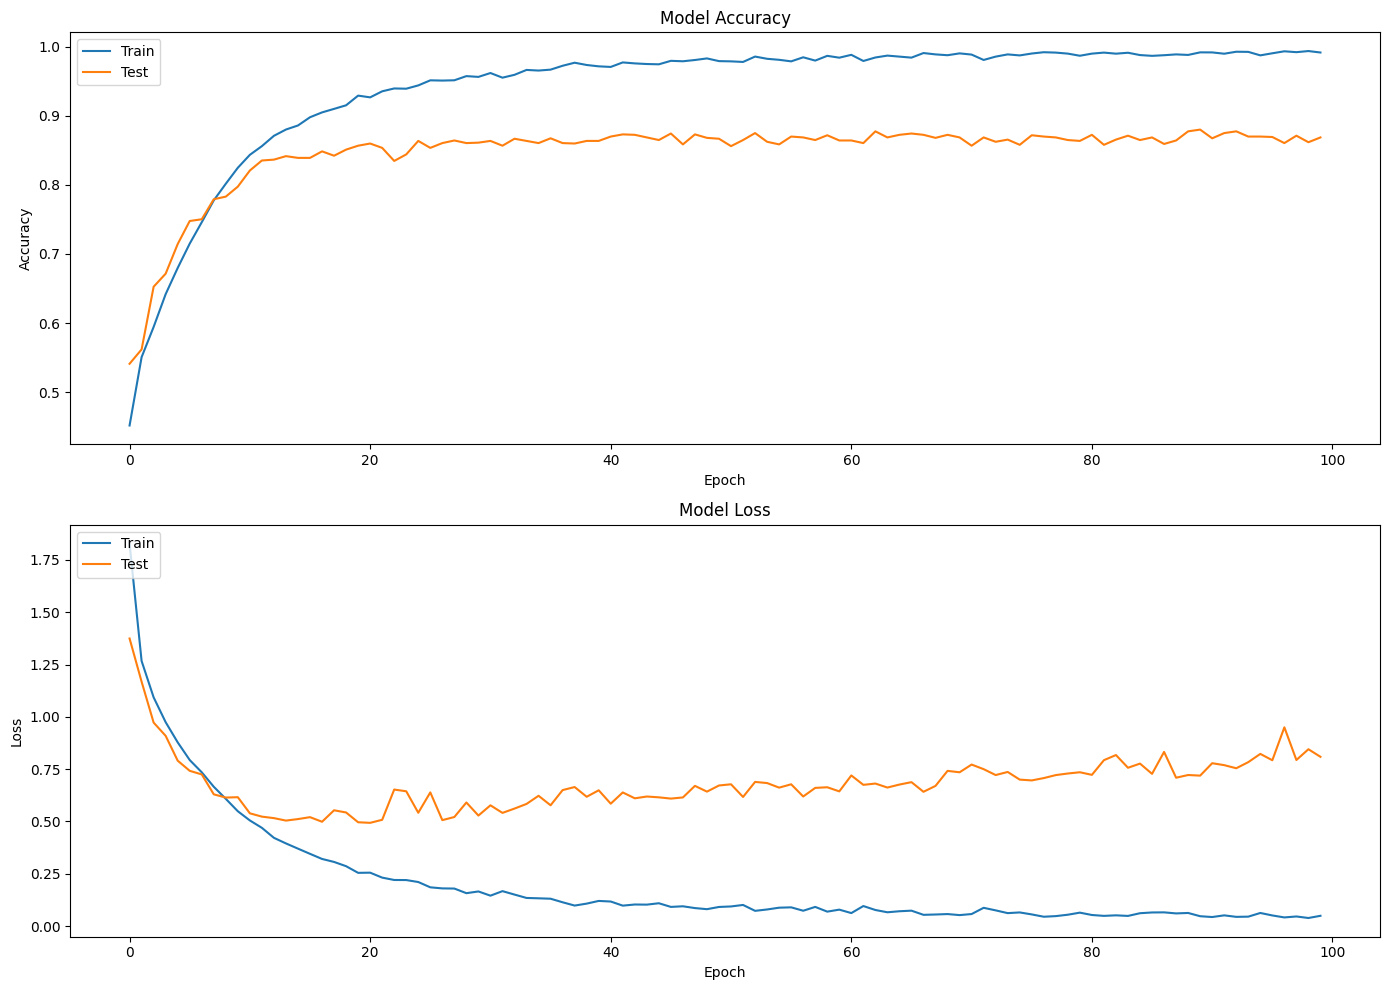

In [113]:
model.plot_train_test_curve(histry)

In [119]:
model.evaluate(X_test,Y_test)

124/124 [==============================] - 2s 11ms/step - loss: 0.8529 - accuracy: 0.8633


[0.852871298789978, 0.8632694482803345]

In [116]:
model.save('/content/drive/MyDrive/your_model_text20.h5')

In [117]:
from keras.models import  load_model
def padd(arr):
    for i in range(20-len(arr)):
        arr.append('<pad>')
    return arr[:20]

def predict(text):

    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

    #stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    text = ' '.join(filtered_sentence)
        
    feel_arr = word_tokenize(text)
      
    
   
# call the padd function for each sentence in feel_arr
    feel_arr=padd(feel_arr)

    embeddings_index = {}
    with open(vocab_f, encoding='utf8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedded_feel_arr = []
    for word in feel_arr:
        if word.lower() in embeddings_index:
            embedded_feel_arr.append(embeddings_index[word.lower()])
        else:
            embedded_feel_arr.append([0]*50)

    X=np.array(embedded_feel_arr)
  
    X=np.reshape(X,(1,20,50))

    
    model = load_model('/content/drive/MyDrive/your_model_text20.h5')
    y=model.predict(X)
    y=np.argmax(y[0])
    labels=['anger', 'fear', 'happy', 'sadness', 'surprise']
    print(labels[y])

predict("i am scared")

1/1 [==============================] - 1s 883ms/step
sadness


In [114]:
 model = load_model('/content/drive/MyDrive/your_model_text20_100.h5')

In [118]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_22 (Bidirecti  (None, 200)              120800    
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 200)               0         
                                                                 
 dense_44 (Dense)            (None, 64)                12864     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 5)                 325       
                                                                 
Total params: 133,989
Trainable params: 133,989
Non-trainable params: 0
_______________________________________________